## 2. PyTorch Implementation of Generative Adverarial Network (GAN) (50 points)

You are required to implement a simple Generative Adversarial Network (GAN) model and train it on the MNIST dataset. We have provided the main structure of the code in this Jupyter notebook, and you need to complete the code according to the comments.

In [6]:
# prerequisites
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision import datasets, transforms
from torch.autograd import Variable


# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Current device: {device}')

Current device: cuda


In [7]:
# Do not adjust any hyper parameter!
batch_size = 128
lr = 0.0001
z_dim = 100

In [8]:
# MNIST Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5), std=(0.5))
])

train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transform, download=False) # already downloaded
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transform, download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [9]:
# Do not modify the model architecture of `Generator`
class Generator(nn.Module):
    def __init__(self, g_input_dim, g_output_dim):
        super(Generator, self).__init__()       
        self.fc1 = nn.Linear(g_input_dim, 256)
        self.fc2 = nn.Linear(256, 512)
        self.fc3 = nn.Linear(512, 1024)
        self.fc4 = nn.Linear(1024, g_output_dim)
    
    def forward(self, x): 
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = torch.tanh(self.fc4(x))
        
        return x


# Do not modify the model architecture of `Discriminator` 
class Discriminator(nn.Module):
    def __init__(self, d_input_dim):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(d_input_dim, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, 1)
    
    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = torch.sigmoid(self.fc4(x))
        
        return x

In [10]:
# build network
mnist_dim = train_dataset.train_data.size(1) * train_dataset.train_data.size(2)

G = Generator(g_input_dim=z_dim, g_output_dim=mnist_dim).to(device)
D = Discriminator(mnist_dim).to(device)

/home/student001/anaconda3/lib/python3.9/site-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


In [11]:
print(G)
print(D)

Generator(
  (fc1): Linear(in_features=100, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=1024, bias=True)
  (fc4): Linear(in_features=1024, out_features=784, bias=True)
)
Discriminator(
  (fc1): Linear(in_features=784, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=1, bias=True)
)


In [12]:
# loss
loss_fn = nn.BCELoss() 

# optimizer
G_optimizer = torch.optim.Adam(G.parameters(), lr = lr)
D_optimizer = torch.optim.Adam(D.parameters(), lr = lr)

In [13]:
def D_train(x, G, D, mnist_dim, batch_size, z_dim, device):
    #=======================Train the discriminator=======================#
    D.zero_grad()

    # train discriminator on real
    x_real, y_real = x.view(-1, mnist_dim), torch.ones(batch_size, 1)
    x_real, y_real = Variable(x_real.to(device)), Variable(y_real.to(device))

    D_output = D(x_real)
    D_real_loss = loss_fn(D_output, y_real)

    # train discriminator on fake
    z = Variable(torch.randn(batch_size, z_dim).to(device))
    x_fake, y_fake = G(z), Variable(torch.zeros(batch_size, 1).to(device))

    D_output = D(x_fake)
    D_fake_loss = loss_fn(D_output, y_fake)

    # gradient backprop & optimize ONLY D's parameters
    D_loss = D_real_loss + D_fake_loss
    D_loss.backward()
    D_optimizer.step()
        
    return  D_loss.data.item(), G, D


def G_train(G, D, batch_size, z_dim, device):
    #=======================Train the generator=======================#
    ################################################################################
    # TODO (30 points):                                                                        
    G.zero_grad()

    # Generate fake data using random noise z
    z = Variable(torch.randn(batch_size, z_dim).to(device))
    x_fake = G(z)

    # Create labels as real for fake data (to fool the discriminator)
    y_fake = Variable(torch.ones(batch_size, 1).to(device))

    # Get the discriminator's predictions for the fake data
    D_output = D(x_fake)

    # Calculate the generator's loss (fake data should be classified as real)
    G_loss = loss_fn(D_output, y_fake)

    # Backpropagate the loss and update the generator's weights
    G_loss.backward()
    G_optimizer.step()

    return G_loss.data.item(), G, D
    # finish the procedure of training the generator                               #
    ################################################################################

In [14]:
D_losses_record, G_losses_record = [], [] # to plot loss

n_epoch = 100
for epoch in range(1, n_epoch+1):           
    D_losses, G_losses = [], []
    for batch_idx, (x, _) in enumerate(train_loader):
        D_loss, G, D = D_train(x, G, D, mnist_dim, batch_size, z_dim, device)
        G_loss, G, D = G_train(G, D, batch_size, z_dim, device)
        D_losses.append(D_loss)
        G_losses.append(G_loss)

    D_losses_record.append(torch.tensor(D_losses).mean().item())
    G_losses_record.append(torch.tensor(G_losses).mean().item())
    print(
        f'[{epoch}/{n_epoch}]: '
        f'loss_d: {torch.tensor(D_losses).mean():.3f}, '
        f'loss_g: {torch.tensor(G_losses).mean():.3f}'
    )

[1/100]: loss_d: 0.772, loss_g: 2.559
[2/100]: loss_d: 1.188, loss_g: 2.141
[3/100]: loss_d: 1.188, loss_g: 1.211
[4/100]: loss_d: 1.075, loss_g: 2.137
[5/100]: loss_d: 0.660, loss_g: 2.421
[6/100]: loss_d: 0.454, loss_g: 3.826
[7/100]: loss_d: 0.285, loss_g: 4.216
[8/100]: loss_d: 0.374, loss_g: 4.415
[9/100]: loss_d: 0.300, loss_g: 4.869
[10/100]: loss_d: 0.412, loss_g: 3.859
[11/100]: loss_d: 0.335, loss_g: 4.273
[12/100]: loss_d: 0.330, loss_g: 4.188
[13/100]: loss_d: 0.278, loss_g: 4.449
[14/100]: loss_d: 0.362, loss_g: 4.509
[15/100]: loss_d: 0.339, loss_g: 4.454
[16/100]: loss_d: 0.217, loss_g: 4.429
[17/100]: loss_d: 0.276, loss_g: 4.600
[18/100]: loss_d: 0.258, loss_g: 4.341
[19/100]: loss_d: 0.261, loss_g: 4.533
[20/100]: loss_d: 0.227, loss_g: 4.762
[21/100]: loss_d: 0.254, loss_g: 4.911
[22/100]: loss_d: 0.205, loss_g: 4.707
[23/100]: loss_d: 0.229, loss_g: 4.804
[24/100]: loss_d: 0.267, loss_g: 4.493
[25/100]: loss_d: 0.273, loss_g: 4.148
[26/100]: loss_d: 0.306, loss_g: 4

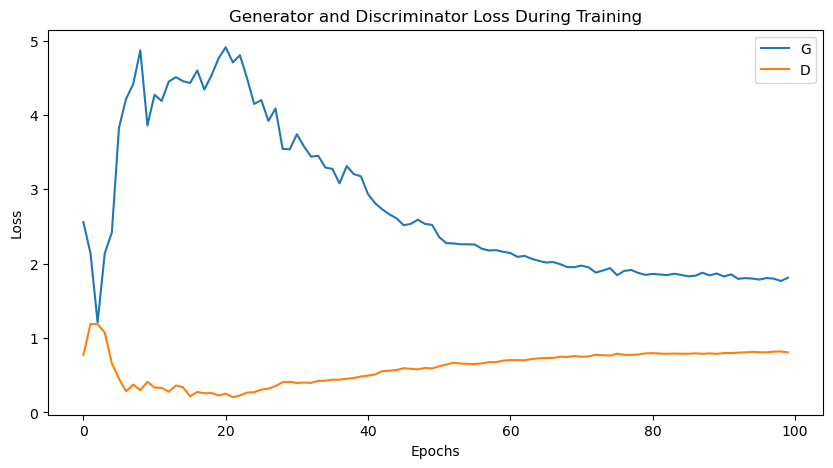

In [15]:
################################################################################
# TODO (10 points):                                                                        #
# you need to plot the training loss of generator and discriminator            #
# you may need to modify the training code to record the corresponding loss    #
plt.figure(figsize=(10, 5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses_record, label="G")
plt.plot(D_losses_record, label="D")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()
################################################################################

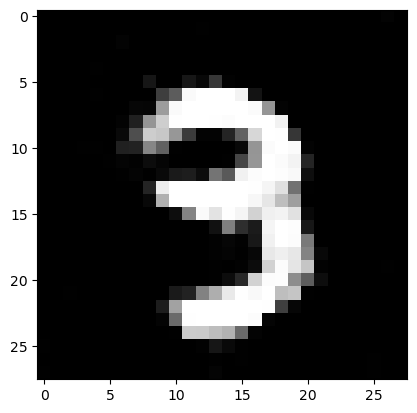

In [23]:
################################################################################
# TODO (10 points):                                                                        #
# you need to generate an image with the trained generator                     #
# a sample result is given as follows                                      #
def generate_image(generator, z_dim, device):
    # 生成随机噪声
    z = Variable(torch.randn(1, z_dim).to(device))

    # 生成图像
    generator.eval()  # 将生成器设置为评估模式
    with torch.no_grad():
        fake_image = generator(z).to('cpu').view(28, 28)
    
    # 将生成的图像转换为可视化的格式
    fake_image = fake_image.detach().numpy()
    plt.imshow(fake_image, interpolation='nearest', cmap='gray')
    plt.show()

# 使用训练好的生成器生成一张图像
generate_image(G, z_dim, device)
################################################################################
